In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew  
%matplotlib inline

In [2]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [5]:
test.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         4
LotFrontage    227
LotArea          0
dtype: int64

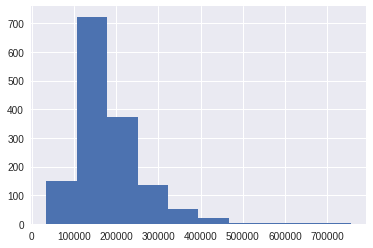

In [6]:
# data is right skewed
train['SalePrice'].hist()

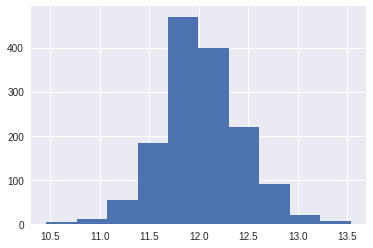

In [7]:
# After log the deviation seems to be normal 
np.log1p(train['SalePrice']).hist()

In [8]:
# get numeric and non numeric cols
numeric_cols = [col for col in train.columns if train[col].dtype!="object" ]
categorical_cols = [col for col in train.columns if col not in numeric_cols]

In [9]:
bothdf = pd.concat([train,test],axis=0)

In [10]:
empty_df =  pd.DataFrame(bothdf.isnull().sum(),columns=['Empty Values'])
empty_df[empty_df['Empty Values']>1000]

,Empty Values
Alley,2721
Fence,2348
FireplaceQu,1420
MiscFeature,2814
PoolQC,2909
SalePrice,1459


In [11]:
bothdf = bothdf.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=1)
empty_df = empty_df.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=0)


In [12]:
empty_df = empty_df[empty_df['Empty Values']>0]
empty_df = empty_df.sort_values(ascending=False,by='Empty Values')
empty_df

,Empty Values
SalePrice,1459
LotFrontage,486
GarageYrBlt,159
GarageQual,159
GarageFinish,159
GarageCond,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


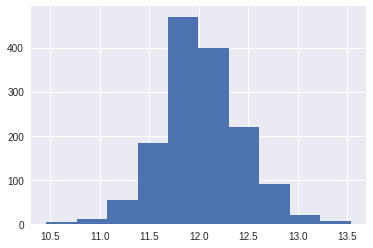

In [13]:
train['SalePrice'] = np.log1p(train['SalePrice'])
train['SalePrice'].hist()

In [14]:
reqColumns = train.columns.difference(['Id','SalePrice'])

In [15]:
removecols = [col for col in bothdf.columns if col not in reqColumns] 

In [16]:
bothdf.drop(removecols,axis=1,inplace=True)

In [17]:
numerical_data = [col for col in bothdf.columns if bothdf[col].dtype!="object"] 
numerical_data

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [18]:
from scipy.stats import skew
skewed_data = train[numerical_data].apply(lambda x: skew(x.dropna()))
skewed_data

1stFlrSF          1.375342
2ndFlrSF          0.812194
3SsnPorch        10.293752
BedroomAbvGr      0.211572
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
BsmtUnfSF         0.919323
EnclosedPorch     3.086696
Fireplaces        0.648898
FullBath          0.036524
GarageArea        0.179796
GarageCars       -0.342197
GarageYrBlt      -0.648708
GrLivArea         1.365156
HalfBath          0.675203
KitchenAbvGr      4.483784
LotArea          12.195142
LotFrontage       2.160866
LowQualFinSF      9.002080
MSSubClass        1.406210
MasVnrArea        2.666326
MiscVal          24.451640
MoSold            0.211835
OpenPorchSF       2.361912
OverallCond       0.692355
OverallQual       0.216721
PoolArea         14.813135
ScreenPorch       4.117977
TotRmsAbvGrd      0.675646
TotalBsmtSF       1.522688
WoodDeckSF        1.539792
YearBuilt        -0.612831
YearRemodAdd     -0.503044
YrSold            0.096170
dtype: float64

In [19]:
skewed_data = skewed_data[skewed_data > 0.80]
skewed_data

1stFlrSF          1.375342
2ndFlrSF          0.812194
3SsnPorch        10.293752
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtHalfBath      4.099186
BsmtUnfSF         0.919323
EnclosedPorch     3.086696
GrLivArea         1.365156
KitchenAbvGr      4.483784
LotArea          12.195142
LotFrontage       2.160866
LowQualFinSF      9.002080
MSSubClass        1.406210
MasVnrArea        2.666326
MiscVal          24.451640
OpenPorchSF       2.361912
PoolArea         14.813135
ScreenPorch       4.117977
TotalBsmtSF       1.522688
WoodDeckSF        1.539792
dtype: float64

In [20]:
bothdf[skewed_data.index] = np.log1p(bothdf[skewed_data.index])
bothdf

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,6.753438,6.751101,0.000000,3,1Fam,TA,No,6.561031,0.000000,GLQ,...,WD,0.000000,Pave,8,6.753438,AllPub,0.000000,2003,2003,2008
1,7.141245,0.000000,0.000000,3,1Fam,TA,Gd,6.886532,0.000000,ALQ,...,WD,0.000000,Pave,6,7.141245,AllPub,5.700444,1976,1976,2007
2,6.825460,6.765039,0.000000,3,1Fam,TA,Mn,6.188264,0.000000,GLQ,...,WD,0.000000,Pave,6,6.825460,AllPub,0.000000,2001,2002,2008
3,6.869014,6.629363,0.000000,3,1Fam,Gd,No,5.379897,0.000000,ALQ,...,WD,0.000000,Pave,7,6.629363,AllPub,0.000000,1915,1970,2006
4,7.044033,6.960348,0.000000,4,1Fam,TA,Av,6.486161,0.000000,GLQ,...,WD,0.000000,Pave,9,7.044033,AllPub,5.262690,2000,2000,2008
5,6.680855,6.340359,5.771441,1,1Fam,TA,No,6.597146,0.000000,GLQ,...,WD,0.000000,Pave,5,6.680855,AllPub,3.713572,1993,1995,2009
6,7.435438,0.000000,0.000000,3,1Fam,TA,Av,7.222566,0.000000,GLQ,...,WD,0.000000,Pave,7,7.430707,AllPub,5.545177,2004,2005,2007
7,7.010312,6.891626,0.000000,3,1Fam,TA,Mn,6.756932,3.496508,ALQ,...,WD,0.000000,Pave,7,7.010312,AllPub,5.463832,1973,1973,2009
8,6.930495,6.624065,0.000000,2,1Fam,TA,No,0.000000,0.000000,Unf,...,WD,0.000000,Pave,8,6.859615,AllPub,4.510860,1931,1950,2008
9,6.982863,0.000000,0.000000,2,2fmCon,TA,No,6.747587,0.000000,GLQ,...,WD,0.000000,Pave,5,6.899723,AllPub,0.000000,1939,1950,2008


In [21]:
bothdf = pd.get_dummies(bothdf)
bothdf.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.000000,5.017280,0.000000,...,0,0,0,0,0,1,0,1,1,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,0.693147,5.652489,0.000000,...,0,0,0,0,0,1,0,1,1,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.000000,6.075346,0.000000,...,0,0,0,0,0,1,0,1,1,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.000000,6.293419,5.609472,...,0,0,0,0,0,1,0,1,1,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.000000,6.196444,0.000000,...,0,0,0,0,0,1,0,1,1,0


In [22]:
bothdf = bothdf.fillna(bothdf.mean())

In [23]:
bothdf.isnull().sum()

1stFlrSF                 0
2ndFlrSF                 0
3SsnPorch                0
BedroomAbvGr             0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtFullBath             0
BsmtHalfBath             0
BsmtUnfSF                0
EnclosedPorch            0
Fireplaces               0
FullBath                 0
GarageArea               0
GarageCars               0
GarageYrBlt              0
GrLivArea                0
HalfBath                 0
KitchenAbvGr             0
LotArea                  0
LotFrontage              0
LowQualFinSF             0
MSSubClass               0
MasVnrArea               0
MiscVal                  0
MoSold                   0
OpenPorchSF              0
OverallCond              0
OverallQual              0
PoolArea                 0
ScreenPorch              0
                        ..
RoofMatl_Metal           0
RoofMatl_Roll            0
RoofMatl_Tar&Grv         0
RoofMatl_WdShake         0
RoofMatl_WdShngl         0
RoofStyle_Flat           0
R

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bothdf[numerical_data])

In [25]:
X = pd.DataFrame()
X['Feature'] = numerical_data
for i,feature in enumerate(numerical_data):    
    X['Old Variance'] = np.var(test[feature])
    X['Scaled Feature'] = np.var(scaled_data[:,i])
X

,Feature,Old Variance,Scaled Feature
0,1stFlrSF,1.693366,1.0
1,2ndFlrSF,1.693366,1.0
2,3SsnPorch,1.693366,1.0
3,BedroomAbvGr,1.693366,1.0
4,BsmtFinSF1,1.693366,1.0
5,BsmtFinSF2,1.693366,1.0
6,BsmtFullBath,1.693366,1.0
7,BsmtHalfBath,1.693366,1.0
8,BsmtUnfSF,1.693366,1.0
9,EnclosedPorch,1.693366,1.0


In [26]:
both_corr = bothdf.corr()

In [27]:
bothdf.drop(['BsmtHalfBath','BsmtFinSF2'],axis=1,inplace=True)

Model Selection

In [42]:
X = bothdf.iloc[:train.shape[0],]
X.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753438,6.751101,0.0,3,6.561031,1.0,5.017280,0.000000,0,2,...,0,0,0,0,0,1,0,1,1,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,5.652489,0.000000,1,2,...,0,0,0,0,0,1,0,1,1,0
2,6.825460,6.765039,0.0,3,6.188264,1.0,6.075346,0.000000,1,2,...,0,0,0,0,0,1,0,1,1,0
3,6.869014,6.629363,0.0,3,5.379897,1.0,6.293419,5.609472,1,1,...,0,0,0,0,0,1,0,1,1,0
4,7.044033,6.960348,0.0,4,6.486161,1.0,6.196444,0.000000,1,2,...,0,0,0,0,0,1,0,1,1,0


In [41]:
y = train['SalePrice']
y.head() 

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [129]:
from sklearn.model_selection import cross_val_score
def RMSError(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [133]:
from sklearn.svm import SVR
model_one = SVR(gamma=0.05)
print("RMSError: ",RMSError(model_one).mean()*100)
print("Standard Dev: ", RMSError(model_one).std()*2*100)

RMSError:  39.2176104484
Standard Dev:  2.95289742216


In [126]:
from sklearn.tree import DecisionTreeRegressor
model_one = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=2)
print("RMSError: ",RMSError(model_one).mean()*100)
print("Standard Dev: ", RMSError(model_one).std()*2*100)

RMSError:  29.327932826
Standard Dev:  1.57051793158


In [145]:
from sklearn.ensemble import RandomForestRegressor
model_rreg = RandomForestRegressor(n_estimators=15,n_jobs=-1)
print("RMSError: ",RMSError(model_one).mean()*100)
print("Standard Dev: ", RMSError(model_one).std()*2*100)

RMSError:  14.7891823626
Standard Dev:  1.49138020299


In [135]:
from sklearn.linear_model import Lasso
model_one = Lasso(alpha = 0.01)
print("RMSError: ",RMSError(model_one).mean()*100)
print("Standard Dev: ", RMSError(model_one).std()*2*100)

RMSError:  15.3818298573
Standard Dev:  2.78016258833


In [151]:
model_rreg.fit(X,y)
preds = model_rreg.predict(bothdf.iloc[train.shape[0]:])
preds

array([ 11.72384409,  11.94489294,  12.10907028, ...,  11.83694887,
        11.60863287,  12.38553512])

In [152]:
preds_actual = np.expm1(preds)
preds_actual

array([ 123480.18664882,  154027.50232338,  181509.77103488, ...,
        138266.96732743,  110042.70335473,  239313.80064229])

In [153]:
preds_actual.shape

(1459,)